In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

import mnist_data_lib
import mnist_vae_lib
import vae_utils

import semisuper_vae_training_lib as ss_lib

import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Load data

In [2]:
seed = 901

In [3]:
np.random.seed(seed)
_ = torch.manual_seed(seed)

# LOAD DATA
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample=1.0)

In [4]:
seed = 34534

np.random.seed(seed)
_ = torch.manual_seed(seed)

print('num_train_labeled: ', train_set_labeled.num_images)
print('num_train_unlabled: ', train_set_unlabeled.num_images)

print('num_test: ', test_set.num_images)

num_train_labeled:  6000
num_train_unlabled:  54000
num_test:  10000


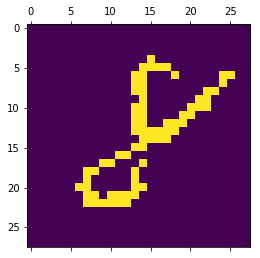

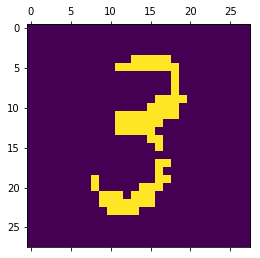

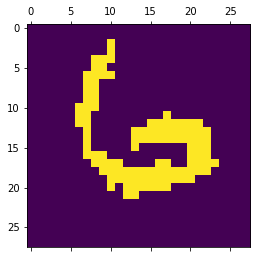

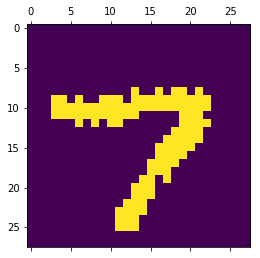

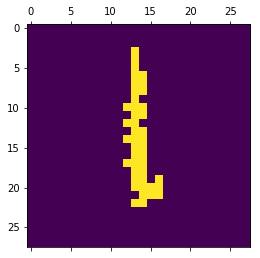

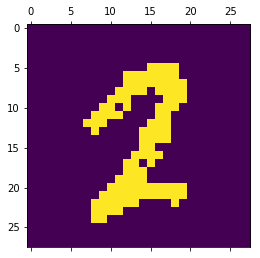

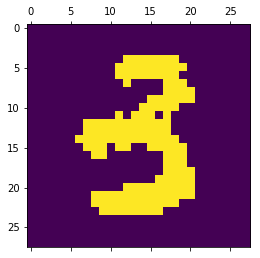

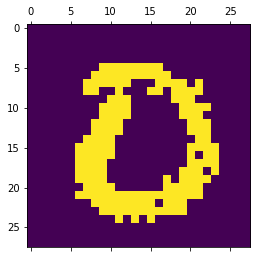

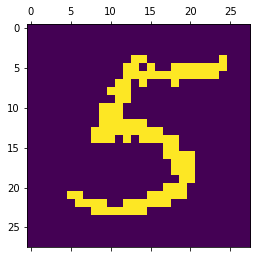

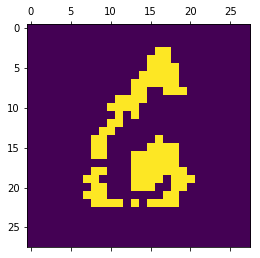

In [5]:
for i in range(10): 
    plt.matshow(train_set_unlabeled[i]['image'].squeeze())
    assert np.all(train_set_unlabeled[i]['image'].detach().numpy() <= 1)
    assert np.all(train_set_unlabeled[i]['image'].detach().numpy() >= 0)

In [6]:
batchsize = 50

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=batchsize,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=batchsize,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batchsize,
                shuffle=False)


In [7]:
for batch_idx, d in enumerate(train_loader_labeled):
    labeled_data = d
    break
    
for batch_idx, d in enumerate(train_loader_unlabeled):
    unlabeled_data = d
    break
    
for batch_idx, d in enumerate(test_loader):
    test_data = d
    break


# Define VAE

In [8]:
latent_dim = 8
n_classes = 10
slen = train_set_unlabeled[0]['image'].shape[0]

In [9]:
vae, classifier = mnist_vae_lib.get_mnist_vae_and_classifier(latent_dim = latent_dim, 
                                                                n_classes = n_classes, 
                                                               slen = slen)

In [ ]:
'./mnist_vae_results/'

In [11]:
# Load results

file_base = './mnist_vae_results/gumbel_vae_'
classifier_file = file_base + 'classifier_final' 
vae_file = file_base + 'vae_final'

vae.load_state_dict(torch.load(vae_file,
                               map_location=lambda storage, loc: storage))

classifier.load_state_dict(torch.load(classifier_file,
                               map_location=lambda storage, loc: storage))


vae.eval()

MNISTVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=794, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=16, bias=True)
  )
  (decoder): MLPDecoder(
    (fc1): Linear(in_features=18, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
)

# Check losses

In [12]:
batch_losses = np.load(file_base + 'batch_losses.npy')

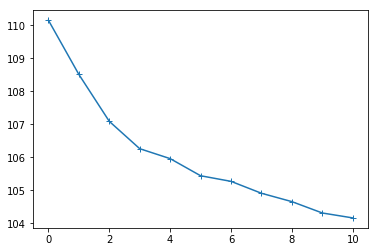

In [13]:
# plot losses
plt.plot(batch_losses, '+-')

In [14]:
train_losses = np.load(file_base + 'train_losses.npy')
test_losses = np.load(file_base + 'test_losses.npy')

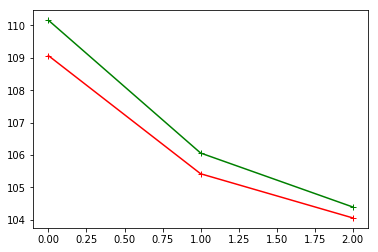

In [15]:
plt.plot(test_losses, 'r-+')
plt.plot(train_losses, 'g-+')

In [16]:
train_accuracies = np.load(file_base + 'train_accuracy.npy')
test_accuracies = np.load(file_base + 'test_accuracy.npy')

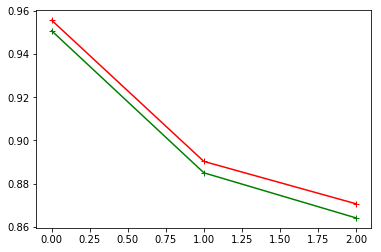

In [17]:
plt.plot(test_accuracies, 'r-+')
plt.plot(train_accuracies, 'g-+')

In [18]:
image = labeled_data['image']
log_q = classifier(image)
z = torch.argmax(log_q, dim = 1)

In [19]:
torch.max(torch.exp(log_q), dim = 1)

(tensor([ 0.4402,  1.0000,  0.9530,  0.3653,  0.8471,  0.3100,  0.9839,
          0.9672,  0.6877,  0.8022,  0.7984,  0.6592,  0.9554,  0.9992,
          0.5369,  0.9599,  0.5824,  0.7076,  0.9986,  0.7018,  0.5735,
          0.8874,  0.9999,  0.9688,  0.5850,  0.3690,  1.0000,  0.6148,
          0.9999,  0.4459,  0.5109,  0.9555,  0.7735,  1.0000,  0.9539,
          0.9921,  0.3938,  0.5280,  0.7797,  0.1184,  0.8317,  0.6758,
          0.9787,  0.9960,  0.7313,  0.9908,  0.2873,  0.9009,  0.8587,
          0.5857]),
 tensor([ 4,  6,  1,  0,  7,  2,  1,  1,  7,  7,  3,  2,  1,  5,
          9,  3,  9,  4,  5,  2,  6,  5,  5,  4,  7,  3,  4,  2,
          5,  8,  8,  0,  4,  6,  1,  2,  3,  8,  7,  8,  1,  3,
          1,  6,  0,  2,  7,  3,  9,  8]))

In [20]:
loss = vae_utils.get_labeled_loss(vae, image, z).mean()

In [21]:
loss

tensor(103.7065)

In [22]:
batch_losses[-1]

104.160736

# Check reconstructions

In [23]:
one_hot_z = vae_utils.get_one_hot_encoding_from_int(z, n_classes)

In [24]:
latent_means, latent_std, latent_samples, image_mean = \
    vae.forward(image, one_hot_z)

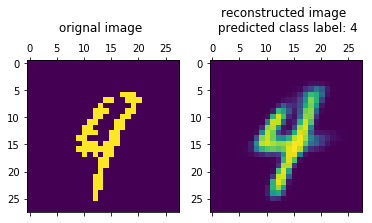

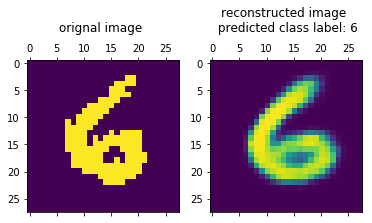

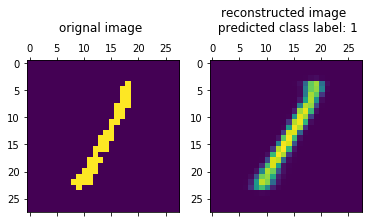

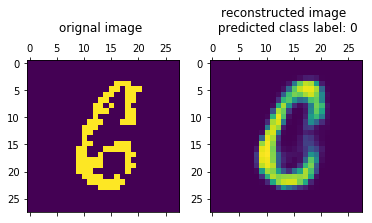

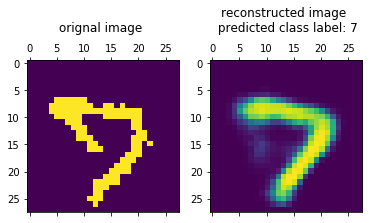

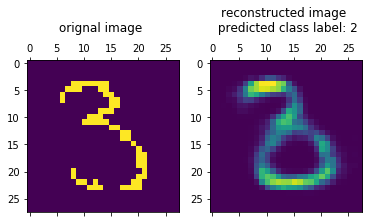

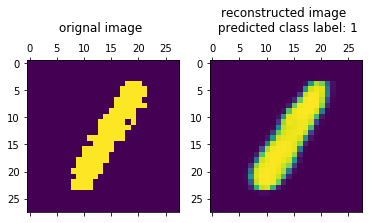

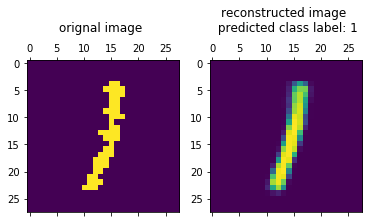

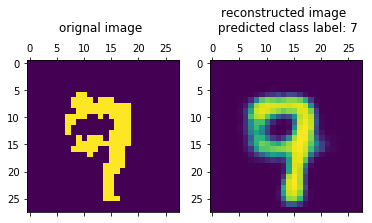

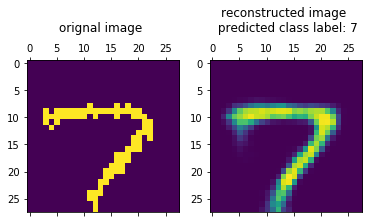

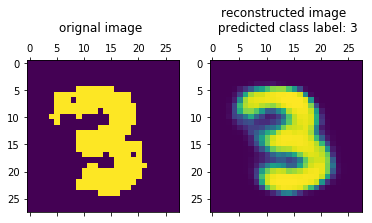

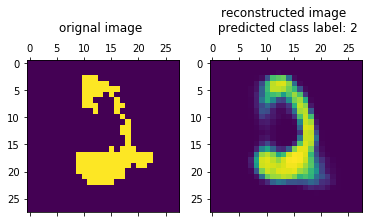

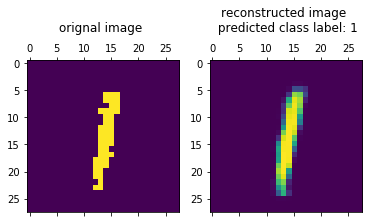

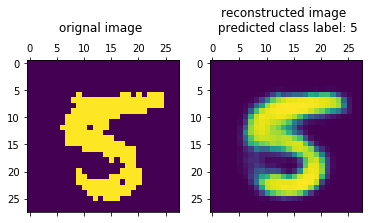

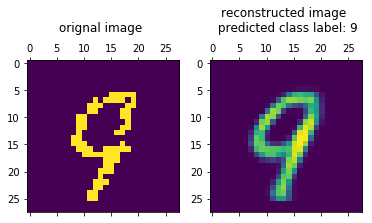

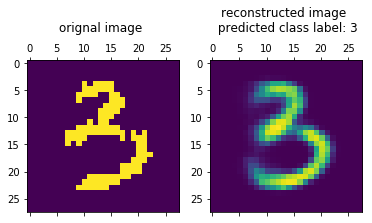

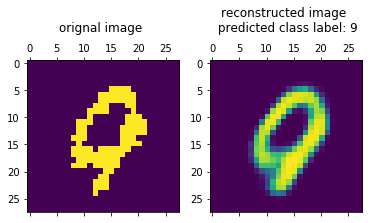

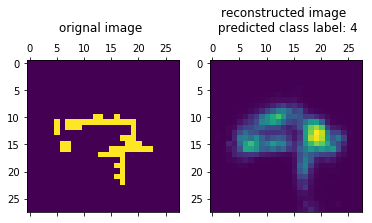

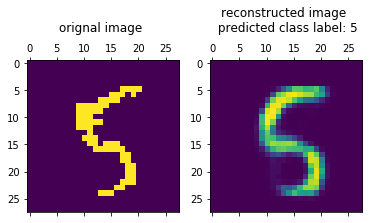

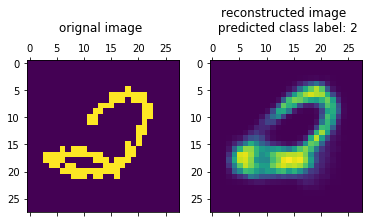

In [25]:
figsize = 6
for i in range(0, 20): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(image[i, :, :])
    axarr[1].matshow(image_mean[i, :, :].detach())
    
    axarr[0].set_title('orignal image \n')
    axarr[1].set_title('reconstructed image \n predicted class label: {}\n'.format(z[i]))

# check conditional generation

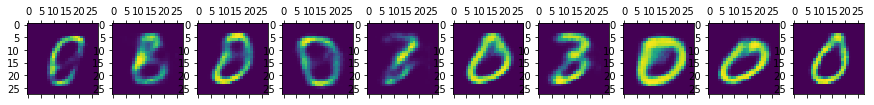

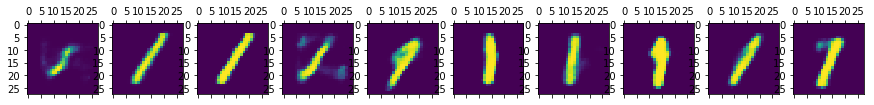

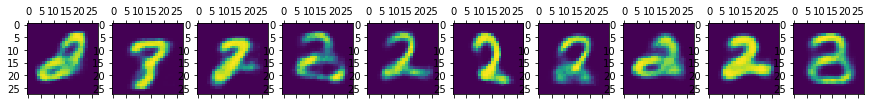

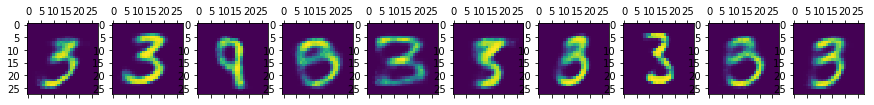

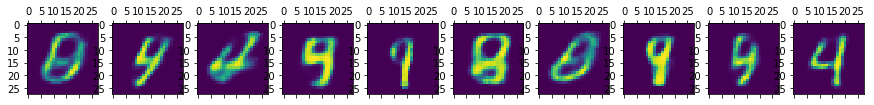

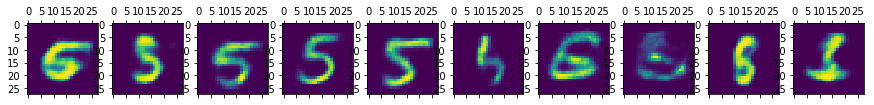

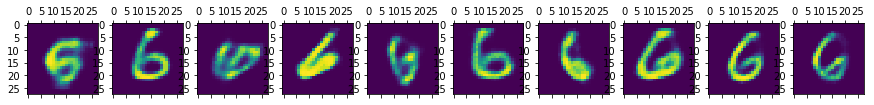

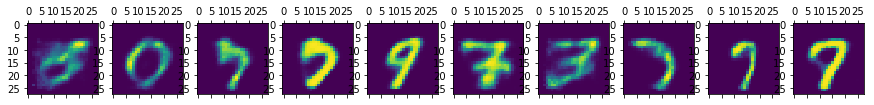

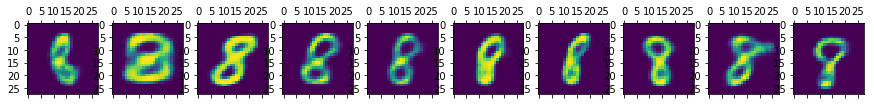

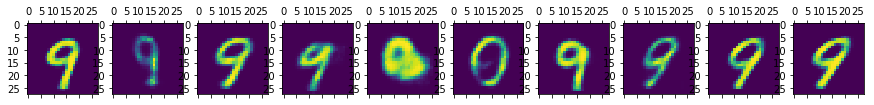

In [26]:
for i in range(10): 
    num = 10
    latent_params = torch.randn((10, latent_dim)) 

    digit = i
    one_hot_z = vae_utils.get_one_hot_encoding_from_int(torch.ones(num) * digit, n_classes)
    recon_mean = vae.decoder(latent_params, one_hot_z)

    f, axarr = plt.subplots(1, num, figsize=(15, 15))

    for i in range(0, num): 
        axarr[i].matshow(recon_mean[i, :, :].detach())


In [28]:
nsample2_batch_losses = np.load('./mnist_vae_results/deleteme/ss_vae_nsample2_batch_losses.npy')

In [29]:
topk1_batch_losses = np.load('./mnist_vae_results/ss_vae_topk1_batch_losses.npy')

In [31]:
topk10_batch_losses = np.load('./mnist_vae_results/ss_vae_topk10_batch_losses.npy')
topk0_batch_losses = np.load('./mnist_vae_results/ss_vae_reinforce_batch_losses.npy')

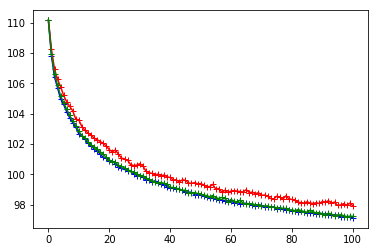

In [34]:
plt.plot(topk10_batch_losses, 'b+-')
plt.plot(topk0_batch_losses, 'r+-')
plt.plot(topk1_batch_losses, 'g+-')
#plt.plot(nsample2_batch_losses, '+-')


In [42]:
gumbel_batch_losses = np.load('./mnist_vae_results/deleteme/gumbel_vae_batch_losses.npy')

In [43]:
reinforce_nobs_batch_losses = np.load('./mnist_vae_results/ss_vae_reinforce_nobs_batch_losses.npy')

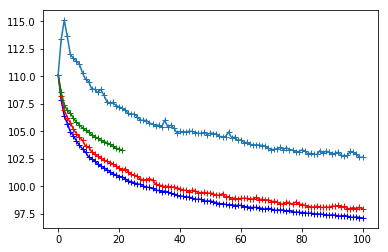

In [45]:
plt.plot(topk10_batch_losses, 'b+-')
plt.plot(topk0_batch_losses, 'r+-')
plt.plot(gumbel_batch_losses, 'g+-')
plt.plot(reinforce_nobs_batch_losses, '+-')